# Segmentation baselines

## Init

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PFCS.scripts.gt_plot import read_data
from pathlib import Path
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler
import datetime as dt

In [2]:
from claspy.data_loader import load_has_dataset
from claspy.segmentation import BinaryClaSPSegmentation

In [3]:
from aeon.segmentation import HidalgoSegmenter, GreedyGaussianSegmenter
from aeon.visualisation.learning_task._segmentation import (
    plot_series_with_change_points,
)
from aeon.visualisation.series._series import plot_series

In [4]:
import ruptures as rpt

In [5]:
from segmentation_utils import (
    extract_eef_data_from_rosbag,
    get_ground_truth_segmentation,
)

In [6]:
# %matplotlib ipympl

## Data files

In [7]:
data_path_root = Path("../table-task-ur5e")
data_path_root.exists()

True

In [8]:
bagfiles = list(data_path_root.glob("*.bag"))
bagfiles

[PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-08-23_2025-08-05-21-08-23.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-33-31_2025-08-05-21-33-31.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-36-29_2025-08-05-21-36-29.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-08-05_21-43-41_2025-08-05-21-43-41.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-04_18-10-23_2025-09-04-18-10-23_test-image.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_16-53-14_2025-09-08-16-53-14_okayish.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

In [9]:
filenum = -1
bagfile = bagfiles[filenum]
bagfile

PosixPath('../table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')

In [10]:
ground_truth_segm_file = data_path_root / "table_task_UR5e_ground_truth.json"
ground_truth_segm_file.exists()

True

## Preprocessing

In [11]:
traj = extract_eef_data_from_rosbag(bagfile)

Extracting TF & gripper data from Bag file...


  0%|          | 0/183488 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓


In [38]:
df = tf_df.diff().mean().timestamp
df

Timedelta('0 days 00:00:00.002001423')

In [46]:
downsampling = 10

In [47]:
freq = 1 / (0.002 * downsampling)
freq

50.0

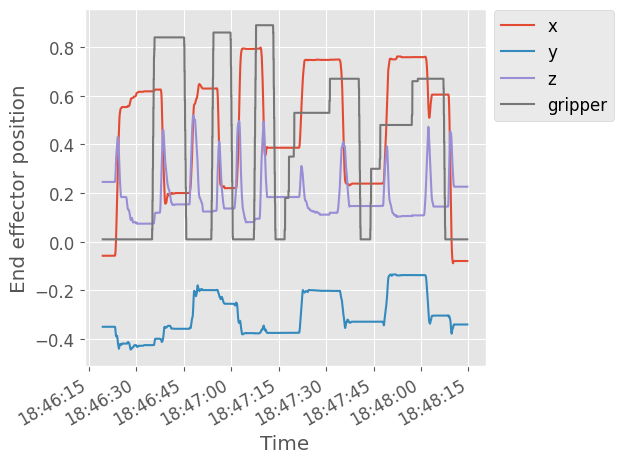

In [12]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    # cmap = mpl.colormaps.get("tab10").colors
    ax.plot(tf_df.timestamp, tf_df.x, label="x")  # , color=cmap[0])
    ax.plot(tf_df.timestamp, tf_df.y, label="y")  # , color=cmap[1])
    ax.plot(tf_df.timestamp, tf_df.z, label="z")  # , color=cmap[2])
    ax.plot(gripper_df.timestamp, gripper_df.val, label="gripper")  # , color=cmap[3])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    # ax.legend(loc="best")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

## Ground truth segmentation

In [13]:
gt_segm_dict = get_ground_truth_segmentation(
    ground_truth_segm_file=ground_truth_segm_file, bagfile=bagfile
)
gt_segm_dict

{'filename': 'rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag',
 'HigherLevel': {'plate': {'ini': 1757375183, 'end': 1757375205},
  'cup': {'ini': 1757375207, 'end': 1757375220},
  'napkin': {'ini': 1757375220, 'end': 1757375232},
  'spoon': {'ini': 1757375235, 'end': 1757375258},
  'fork': {'ini': 1757375262, 'end': 1757375288}},
 'LowerLevel': {'reaching': [{'ini': 1757375183, 'end': 1757375194},
   {'ini': 1757375207, 'end': 1757375212},
   {'ini': 1757375220, 'end': 1757375226},
   {'ini': 1757375235, 'end': 1757375253},
   {'ini': 1757375262, 'end': 1757375280}],
  'placing': [{'ini': 1757375197, 'end': 1757375205},
   {'ini': 1757375215, 'end': 1757375220},
   {'ini': 1757375228, 'end': 1757375232},
   {'ini': 1757375253, 'end': 1757375258},
   {'ini': 1757375280, 'end': 1757375288}]}}

### Higher level movements

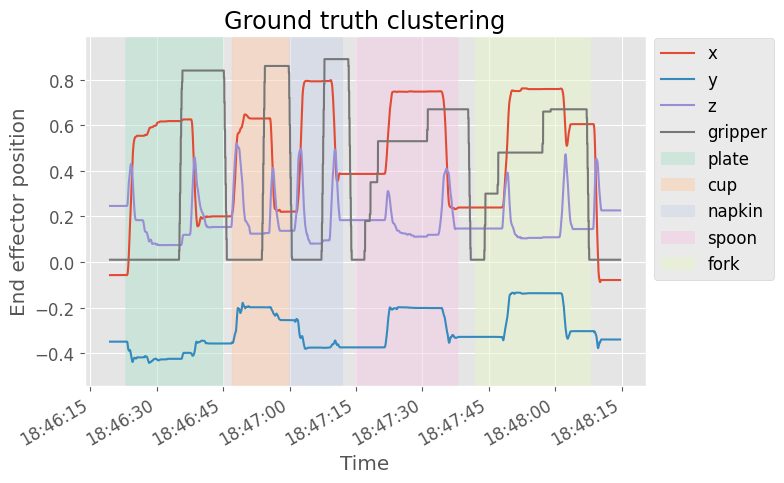

In [34]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmap = mpl.colormaps.get("Pastel2").colors
    ax.plot(tf_df.timestamp, tf_df.x, label="x")  # , color=cmap[0])
    ax.plot(tf_df.timestamp, tf_df.y, label="y")  # , color=cmap[1])
    ax.plot(tf_df.timestamp, tf_df.z, label="z")  # , color=cmap[2])
    ax.plot(gripper_df.timestamp, gripper_df.val, label="gripper")  # , color=cmap[3])

    fill_min = np.min(
        [tf_df.x.min(), tf_df.y.min(), tf_df.z.min(), gripper_df.val.min()]
    )
    fill_max = np.max(
        [tf_df.x.max(), tf_df.y.max(), tf_df.z.max(), gripper_df.val.max()]
    )
    for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
        sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
        xs = tf_df.timestamp[
            (
                tf_df.timestamp
                > pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["ini"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
            & (
                tf_df.timestamp
                < pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["end"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
        ]  # - dt.timedelta(hours=5)
        ax.fill_between(
            x=xs,
            y1=fill_min - 1,
            y2=fill_max + 1,
            color=cmap[sect_i],
            alpha=0.5,
            transform=ax.get_xaxis_transform(),
            label=sect_key,
        )

    ax.set_ylim(bottom=fill_min - 0.1, top=fill_max + 0.1)
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    ax.set_title("Ground truth clustering")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

### Lower level movements

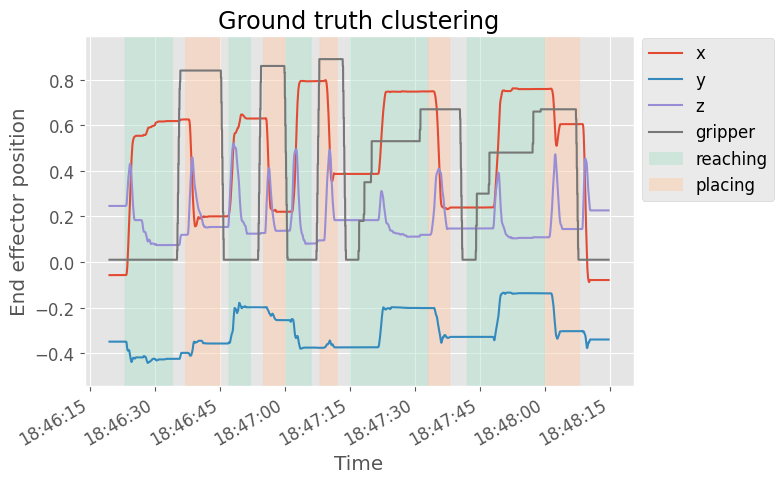

In [35]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmap = mpl.colormaps.get("Pastel2").colors
    ax.plot(tf_df.timestamp, tf_df.x, label="x")  # , color=cmap[0])
    ax.plot(tf_df.timestamp, tf_df.y, label="y")  # , color=cmap[1])
    ax.plot(tf_df.timestamp, tf_df.z, label="z")  # , color=cmap[2])
    ax.plot(gripper_df.timestamp, gripper_df.val, label="gripper")  # , color=cmap[3])

    fill_min = np.min(
        [tf_df.x.min(), tf_df.y.min(), tf_df.z.min(), gripper_df.val.min()]
    )
    fill_max = np.max(
        [tf_df.x.max(), tf_df.y.max(), tf_df.z.max(), gripper_df.val.max()]
    )
    for sect_i, sect_key in enumerate(gt_segm_dict["LowerLevel"].keys()):
        skill_current = gt_segm_dict["LowerLevel"][sect_key]
        for skill_i, skill_val in enumerate(skill_current):
            xs = tf_df.timestamp[
                (
                    tf_df.timestamp
                    > pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["ini"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
                & (
                    tf_df.timestamp
                    < pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["end"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
            ]  # - dt.timedelta(hours=5)
            if skill_i == 0:
                ax.fill_between(
                    x=xs,
                    y1=fill_min - 1,
                    y2=fill_max + 1,
                    color=cmap[sect_i],
                    alpha=0.5,
                    transform=ax.get_xaxis_transform(),
                    label=sect_key,
                )
            else:
                ax.fill_between(
                    x=xs,
                    y1=fill_min - 1,
                    y2=fill_max + 1,
                    color=cmap[sect_i],
                    alpha=0.5,
                    transform=ax.get_xaxis_transform(),
                    # label=sect_key,
                )

    ax.set_ylim(bottom=fill_min - 0.1, top=fill_max + 0.1)
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    ax.set_title("Ground truth clustering")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

## Segmentation

In [16]:
true_cps = np.ones((len(gt_segm_dict["HigherLevel"]) - 1)) * np.nan
for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
    sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
    if sect_i < len(true_cps):
        true_cps[sect_i] = sect_dict_current["end"]
true_cps

array([1.75737520e+09, 1.75737522e+09, 1.75737523e+09, 1.75737526e+09])

In [17]:
labels = gt_segm_dict["HigherLevel"].keys()
labels

dict_keys(['plate', 'cup', 'napkin', 'spoon', 'fork'])

In [18]:
X = tf_df.drop(columns=["timestamp"])
X

,x,y,z
0,-0.057518,-0.349367,0.245931
1,-0.057518,-0.349359,0.245916
2,-0.057527,-0.349371,0.245943
3,-0.057521,-0.349371,0.245940
4,-0.057525,-0.349373,0.245945
...,...,...,...
57562,-0.079063,-0.339990,0.226383
57563,-0.079040,-0.339984,0.226385
57564,-0.079073,-0.339983,0.226388
57565,-0.079063,-0.339978,0.226381


In [19]:
X_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
X_scaled

array([[0.03466644, 0.30296172, 0.38460435],
       [0.03466634, 0.30298799, 0.38457212],
       [0.03465621, 0.30295002, 0.38463162],
       ...,
       [0.01035104, 0.3333613 , 0.3408574 ],
       [0.01036216, 0.33337666, 0.34084089],
       [0.01035894, 0.33336528, 0.34081912]], shape=(57567, 3))

### Multivariate ClaSP

In [20]:
clasp = BinaryClaSPSegmentation(n_segments=5)
# clasp = BinaryClaSPSegmentation(n_segments=len(labels))

In [21]:
pred = clasp.fit_predict(X_scaled)
pred

array([], dtype=float64)

In [22]:
if pred.size == 0:
    print("No segmentation classes found...")
else:
    clasp.plot(
        gt_cps=true_cps,
        heading=f"Segmentation of activity routine: {', '.join(labels)}",
        ts_name="ACC",
        font_size=18,
        file_path="test-multivariate-ClaSP.png",
    )

No segmentation classes found...


### Hidalgo

In [23]:
# hidalgo = HidalgoSegmenter(K=len(labels), q=3, n_iter=2000, burn_in=0.8)
hidalgo = HidalgoSegmenter(K=5, q=3, n_iter=2000, burn_in=0.8)

In [24]:
try:
    cps = hidalgo.fit_predict(X_scaled, axis=0)
    print("Found change points:", cps)
except AssertionError as ae:
    print("\nAssertion error bug...")

/home/kir0ul/Projects/segmentation-baselines/venv/lib64/python3.11/site-packages/aeon/segmentation/_hidalgo.py:176: RuntimeWarning: divide by zero encountered in divide
  mu = np.divide(distances[:, 2], distances[:, 1])



Assertion error bug...


### GGS

In [25]:
# ggs = GreedyGaussianSegmenter(k_max=len(labels), lamb=1, verbose=True)
ggs = GreedyGaussianSegmenter(k_max=5, lamb=1, verbose=True)

In [26]:
cps = ggs.fit_predict(X_scaled, axis=0)
cps

array([0, 0, 0, ..., 5, 5, 5], shape=(57567,), dtype=int32)

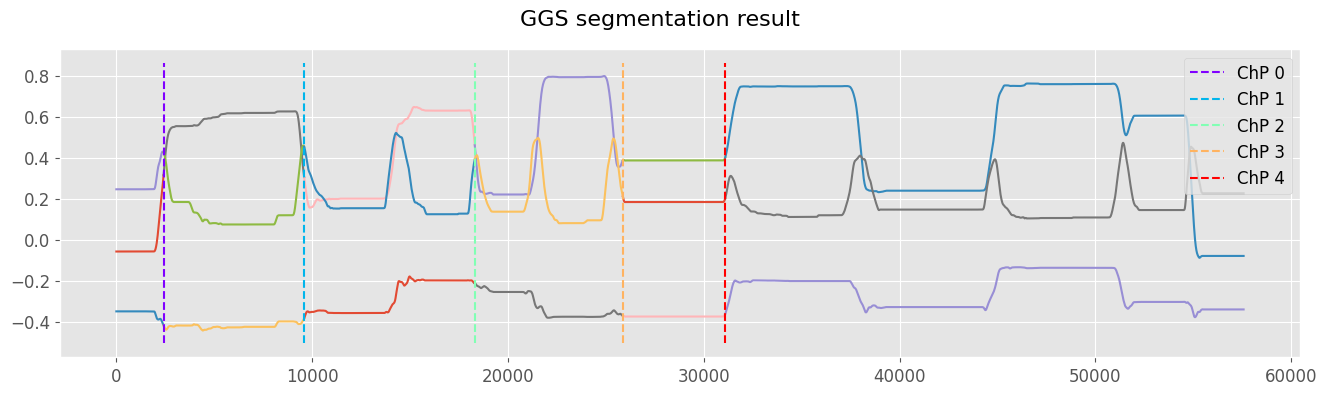

In [27]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plot_series_with_change_points(
        y=X,
        change_points=np.where(np.diff(cps) != 0)[0],
        title="GGS segmentation result",
        font_size=16,
    )
    plt.show()

### ruptures

In [28]:
bkps_iso = [item["end"] for item in gt_segm_dict["HigherLevel"].values()]
bkps_iso

[1757375205, 1757375220, 1757375232, 1757375258, 1757375288]

In [29]:
bkps = np.empty_like(bkps_iso) * np.nan
bkps

array([nan, nan, nan, nan, nan])

In [30]:
for idx in range(len(bkps)):
    bkps[idx] = tf_df[
        tf_df.timestamp
        >= pd.Timestamp(
            dt.datetime.fromtimestamp(bkps_iso[idx]) - dt.timedelta(hours=1),
            tz="EST",
        )
    ].index[0]
bkps

array([12774., 20272., 26267., 39257., 54247.])

In [48]:
# detection
# algo = rpt.Pelt(model="rbf").fit(X_scaled)
# algo = rpt.KernelCPD(kernel="rbf").fit(X_scaled)
algo = rpt.KernelCPD(kernel="cosine").fit(X_scaled)
result = algo.predict(pen=10)
print(result)

[np.int32(2042), np.int32(2414), np.int32(2685), np.int32(4183), np.int32(8172), np.int32(9190), np.int32(9390), np.int32(9661), np.int32(10123), np.int32(10700), np.int32(13794), np.int32(14753), np.int32(15095), np.int32(18136), np.int32(18764), np.int32(21066), np.int32(21289), np.int32(21702), np.int32(21971), np.int32(24938), np.int32(25212), np.int32(25770), np.int32(31180), np.int32(31735), np.int32(37470), np.int32(37872), np.int32(38655), np.int32(44351), np.int32(45074), np.int32(51021), np.int32(51271), np.int32(51815), np.int32(54689), np.int32(54923), np.int32(55291), 57567]


In [49]:
# signal, bkps = rpt.pw_constant(n_samples, n_dims, n_bkps, noise_std=sigma)

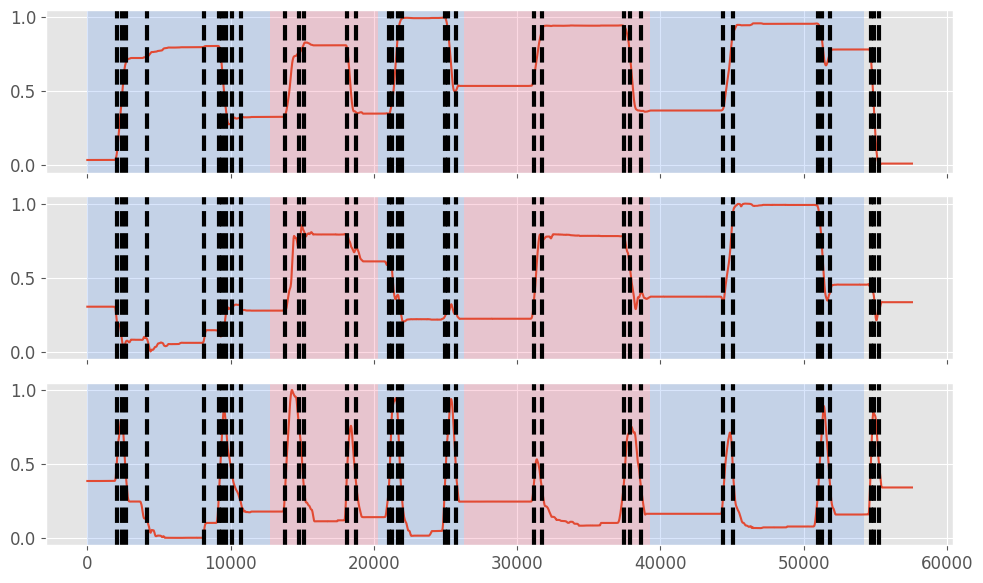

In [50]:
# display
with plt.style.context("ggplot_perso.mplstyle"):
    rpt.display(X_scaled, bkps, result)
    plt.show()